In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy import linalg, stats
import time
import importlib
import sys
from scipy.special import logsumexp
from particles import resampling as rs
from scipy.spatial.distance import cdist

In [2]:
d = 1

In [3]:
ms = 1*np.ones(d)
Sigmas = 5*np.eye(d)
mu0 = np.zeros(d)
Sigma0 = np.eye(d)

In [4]:
Sigmas_inv = linalg.inv(Sigmas)

In [5]:
def logpi_MultiGaussian(x, ms, Sigmas_inv):
    
    # Compute (x - m)
    xm = x - ms

    quad = np.sum(xm @ Sigmas_inv * xm, axis=1)
    
    return -0.5*quad

def SMC_WFR(gamma, Niter, ms, Sigmas, Sigmas_inv, X0, nmcmc):
    d = ms.size
    N = X0.shape[0]
    X = np.zeros((Niter, d, N))
    W = np.zeros((Niter, N))
    X[0, :] = X0.T
    W[0, :] = np.ones(N)/N
    for n in range(1, Niter):
        if (n > 1):
            # resample
            ancestors = rs.resampling('stratified', W[n-1, :])
            X[n-1, :, :] = X[n-1, :, ancestors].T
        # MCMC move
        if(nmcmc > 1):
            Xmcmc = np.zeros((nmcmc, d, N))
            Xmcmc[0, :] = X[n-1, :, :]
            for j in range(1, nmcmc):
                gradient_step = Xmcmc[j-1, :] - gamma*np.matmul(Sigmas_inv, (Xmcmc[j-1, :].T-ms).T)
                Xmcmc[j, :] = gradient_step + np.sqrt(2*gamma)*np.random.normal(size = (d, N))
            X[n, :] = Xmcmc[nmcmc-1, :]
        else:
            gradient_step = X[n-1, :, :] - gamma*np.matmul(Sigmas_inv, (X[n-1, :, :].T-ms).T)
            X[n, :, :] = gradient_step + np.sqrt(2*gamma)*np.random.normal(size = (d, N))
        distSq = -(1.0 / (4 * gamma))*cdist(X[n, :, :].T, gradient_step.T, metric='sqeuclidean')
        weight_denominator = logsumexp(distSq, axis=1)
        logW = (1-np.exp(-gamma))*(logpi_MultiGaussian(X[n, :, :].T, ms, Sigmas_inv)-weight_denominator)
        W[n, :] = rs.exp_and_normalise(logW)
    return X, W


In [6]:
Niter = 400
gamma = 0.01
Nrep = 1
Ns = np.array([50, 100, 500, 1000, 1500, 2000])

In [7]:
mean_smc = np.zeros((Nrep, Ns.size))
var_smc = np.zeros((Nrep, Ns.size))
prob_smc = np.zeros((Nrep, Ns.size))
for j in range(Nrep):
    for i in range(Ns.size):
        N = Ns[i]
        X0 = np.random.normal(size = (d, N))
        x, W = SMC_WFR(gamma, Niter, ms, Sigmas, Sigmas_inv, X0.T, 1)
        mean_smc[j, i] = np.sum(x[-1, 0, :]*W[-1, :])
        var_smc[j, i] = np.sum(x[-1, 0, :]**2*W[-1, :]) - mean_smc[j, i]**2
        prob_smc[j, i] = np.sum((x[-1, :] > ms)*W[-1, :])

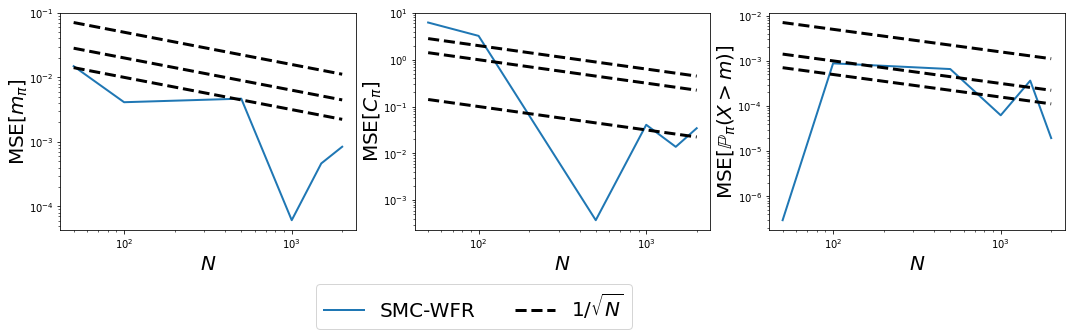

In [8]:
plt.figure(figsize = (18, 4))
plt.subplot(1, 3, 1)
plt.loglog(Ns, np.mean((mean_smc - ms)**2, axis = 0), lw = 2, label = 'SMC-WFR');
plt.loglog(Ns, 0.5*Ns**(-1/2), lw = 3, c='black', linestyle = 'dashed');
plt.loglog(Ns, 0.1*Ns**(-1/2), lw = 3, c='black', linestyle = 'dashed');
plt.loglog(Ns, 0.2*Ns**(-1/2), lw = 3, c='black', linestyle = 'dashed');
plt.xlabel('$N$', fontsize = 20)
plt.ylabel('MSE[$m_\pi$]', fontsize = 20, labelpad=-1)
# plt.legend(fontsize = 20)
plt.subplot(1, 3, 2)
plt.loglog(Ns, np.mean((var_smc - Sigmas)**2, axis = 0), lw = 2, label = 'SMC-WFR');
plt.loglog(Ns, 10*Ns**(-1/2), lw = 3, c='black', linestyle = 'dashed');
plt.loglog(Ns, Ns**(-1/2), lw = 3, c='black', linestyle = 'dashed');
plt.loglog(Ns, 20*Ns**(-1/2), lw = 3, c='black', linestyle = 'dashed');
# plt.legend(fontsize = 20)
plt.xlabel('$N$', fontsize = 20)
plt.ylabel('MSE[$C_\pi$]', fontsize = 20, labelpad=-1)
plt.subplot(1, 3, 3)
plt.loglog(Ns, np.mean((prob_smc - 0.5)**2, axis = 0), lw = 2, label = 'SMC-WFR');
plt.loglog(Ns, 0.05*Ns**(-1/2), lw = 3, c='black', linestyle = 'dashed', label = '$1/\sqrt{N}$');
plt.loglog(Ns, 0.005*Ns**(-1/2), lw = 3, c='black', linestyle = 'dashed');
plt.loglog(Ns, 0.01*Ns**(-1/2), lw = 3, c='black', linestyle = 'dashed');
plt.xlabel('$N$', fontsize = 20)
plt.ylabel('MSE[$\mathbb{P}_\pi(X>m)]$', fontsize = 20, labelpad=-1)
legend = plt.legend(fontsize = 20, ncol = 2, loc = 'lower center', bbox_to_anchor=(-1, -0.5))
# plt.savefig('SMC_WFR_rate_target2.pdf', bbox_inches="tight")

In [9]:
# def export_legend(legend, filename="legend_rate.pdf", expand=[-5,-5,5,5]):
#     fig  = legend.figure
#     fig.canvas.draw()
#     bbox  = legend.get_window_extent()
#     bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
#     bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
#     fig.savefig(filename, dpi="figure", bbox_inches=bbox)

# export_legend(legend)
# plt.show()